<a href="https://colab.research.google.com/github/Gab2697/Surface-classification-EMG/blob/main/IMU_BiomecZoo_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import
import pandas as pd
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.io import loadmat

from keras import layers 
from keras import models
from keras import regularizers
import glob

from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Functions

In [90]:
#================================mat to tensor================================
def mat_to_tensor(path_mat):
  data=loadmat(path_mat)
  keys=list(data['data'].dtype.fields.keys())
  da=np.array(data['data'][keys[0]])
  for i in range(1,len(keys)-2):
      da=np.append(da,data['data'][keys[i]],axis=1)
  da=np.append(da,data['data'][keys[-2]],axis=1)
  da=np.append(da,data['data'][keys[-1]],axis=1)
  da=pd.DataFrame(da,columns=keys)
  Participant= da['Subject']
  Surface= da['Conditions'] 
  # from 2d to 3d
  Ndata=da
  Parameters=Ndata.keys()
  GC_len=Ndata.iloc[1,1].shape[0]
  data1=np.zeros([Ndata.shape[0],GC_len,len(Parameters)-2])
  for i in range(len(Parameters)-2):
    for j in range(len(Ndata[Parameters[i]])):
      data1[j,:,i]=Ndata[Parameters[i]].to_numpy()[j].reshape(GC_len)
  return data1,Participant,Surface
#================================Save pickle file================================
def save_pickle(path_pickle,T):
    f = open(path_pickle, 'wb')
    pickle.dump(T, f)
    f.close()

    return f 
#================================Open pickle file================================
def open_pickle(path_pickle):
    f = open(path_pickle, 'rb')
    T = pickle.load(f)
    f.close()

    return T
#================================final prep CNN================================
def final_prep(data):
  #seperate train and test set
  train_index,test_index,extract=subject_wise_split(np.array(Participant),split=0.15,subject_wise=False,seed=5)
  train_index,test_index=train_index.astype('int64'),test_index.astype('int64')   

  X_train=data[train_index]
  X_test=data[test_index]
  y_train=Surface[train_index]
  y_test=Surface[test_index]

  y_train=y_train.to_numpy()
  y_test=y_test.to_numpy()

  #one hot encoding for label
  X_train=np.asarray(X_train).astype(np.float32) 
  y_train=one_hot(y_train)
  X_test=np.asarray(X_test).astype(np.float32) 
  y_test=one_hot(y_test)
  return X_train,y_train,X_test,y_test
  
#================================subject wise split================================
def subject_wise_split(Participant,subject_wise,split=0.10,seed=42):
    np.random.seed(seed)
    if subject_wise:
        UniqParti=np.unique(Participant)
        num=np.round(UniqParti.shape[0]*split).astype('int64')
        np.random.shuffle(UniqParti)
        extract=UniqParti[0:num]
        test_index=np.array([],dtype='int64')
        for j in extract:
            test_index=np.append(test_index,np.where(Participant==j)[0])
        train_index=np.delete(np.arange(len(Participant)),test_index)
        np.random.shuffle(test_index)
        np.random.shuffle(train_index)

    else:
        I=np.arange(len(Participant)).astype('int64')
        np.random.shuffle(I)
        num=np.round(Participant.shape[0]*split).astype('int64')
        test_index=I[0:num]
        train_index=I[num:]
        extract=np.unique(Participant[test_index])
    return train_index,test_index,extract

#================================One Hot encoding================================
def one_hot(y):
    uniq=np.unique(y)
    y_hot=np.zeros([y.shape[0],uniq.shape[0]])
    for i in range(len(uniq)):
        index=np.where(y==uniq[i])[0]
        y_hot[index,i]=1
    surface_name=uniq
    return y_hot
#================================CNN================================
def CNN_test(input_shape,output_shape):
    model = tf.keras.models.Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [92]:
#call function for Participant 1,2,3,4,5,7,8,9
data_12345789,Participant,Surface=mat_to_tensor('/content/drive/MyDrive/Gab/mat files/P12345789.mat')#P12345789
data_12345789.shape

(8112, 101, 123)

In [94]:
#save pickle file 
data_12345789=save_pickle('/content/drive/MyDrive/Gab/Variables_saved/IMU/data_12345789.pkl',data_12345789)

In [95]:
#open pickle
data_12345789=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/IMU/data_12345789.pkl')

In [97]:
#call split and final labelling function
X_train,y_train,X_test,y_test=final_prep(data_12345789)

#CNN

In [98]:
#call model
model=CNN_test(X_train.shape[1:],2)
#train model
history= model.fit(X_train,y_train, epochs=10, batch_size=200,validation_data=(X_test,y_test)) 

Epoch 1/10
35/35 [==============================] - 6s 138ms/step - loss: 3.7265 - accuracy: 0.5211 - val_loss: 0.6917 - val_accuracy: 0.5481
Epoch 2/10
35/35 [==============================] - 5s 133ms/step - loss: 0.6826 - accuracy: 0.5630 - val_loss: 0.6749 - val_accuracy: 0.6179
Epoch 3/10
35/35 [==============================] - 7s 204ms/step - loss: 0.6640 - accuracy: 0.5952 - val_loss: 0.6568 - val_accuracy: 0.6204
Epoch 4/10
35/35 [==============================] - 5s 134ms/step - loss: 0.6292 - accuracy: 0.6542 - val_loss: 0.6338 - val_accuracy: 0.6984
Epoch 5/10
35/35 [==============================] - 5s 155ms/step - loss: 0.5903 - accuracy: 0.7062 - val_loss: 0.5736 - val_accuracy: 0.7535
Epoch 6/10
35/35 [==============================] - 7s 186ms/step - loss: 0.4941 - accuracy: 0.7659 - val_loss: 0.4460 - val_accuracy: 0.8069
Epoch 7/10
35/35 [==============================] - 11s 310ms/step - loss: 0.4002 - accuracy: 0.8146 - val_loss: 0.4249 - val_accuracy: 0.8053
Epoch

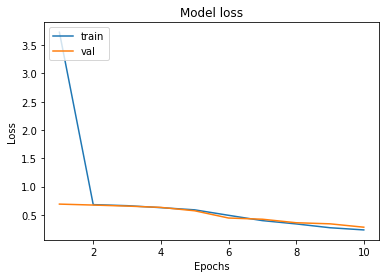

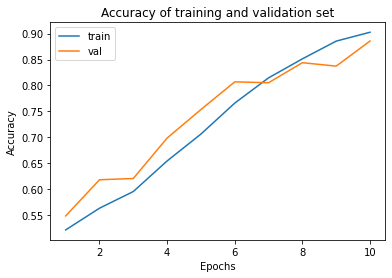

In [99]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Channels available

In [ ]:
#channels 
data= ['SegmentAngularVelocity_Pelvis_x','SegmentAngularVelocity_Pelvis_y','SegmentAngularVelocity_Pelvis_z','SegmentAngularVelocity_Right_Shoulder_x',
    'SegmentAngularVelocity_Right_Shoulder_y','SegmentAngularVelocity_Right_Shoulder_z','SegmentAngularVelocity_Right_Forearm_x','SegmentAngularVelocity_Right_Forearm_y',
    'SegmentAngularVelocity_Right_Forearm_z','SegmentAngularVelocity_Right_Hand_x','SegmentAngularVelocity_Right_Hand_y','SegmentAngularVelocity_Right_Hand_z',
    'SegmentAngularVelocity_Left_Shoulder_x','SegmentAngularVelocity_Left_Shoulder_y','SegmentAngularVelocity_Left_Shoulder_z',
    'SegmentAngularVelocity_Left_Forearm_x','SegmentAngularVelocity_Left_Forearm_y','SegmentAngularVelocity_Left_Forearm_z','SegmentAngularVelocity_Left_Hand_x',
    'SegmentAngularVelocity_Left_Hand_y','SegmentAngularVelocity_Left_Hand_z','SegmentAngularVelocity_Right_Lower_Leg_x','SegmentAngularVelocity_Right_Lower_Leg_y',
    'SegmentAngularVelocity_Right_Lower_Leg_z','SegmentAngularVelocity_Right_Foot_x','SegmentAngularVelocity_Right_Foot_y','SegmentAngularVelocity_Right_Foot_z',
    'SegmentAngularVelocity_Left_Upper_Leg_x','SegmentAngularVelocity_Left_Upper_Leg_y','SegmentAngularVelocity_Left_Upper_Leg_z','SegmentAngularVelocity_Left_Lower_Leg_x',
    'SegmentAngularVelocity_Left_Lower_Leg_y','SegmentAngularVelocity_Left_Lower_Leg_z','SegmentAngularVelocity_Left_Foot_x','SegmentAngularVelocity_Left_Foot_y','SegmentAngularVelocity_Left_Foot_z',
    'JointAnglesZXY_C1_Head_Lateral_Bending','JointAnglesZXY_C1_Head_Axial_Rotation','JointAnglesZXY_C1_Head_Flexion_Extension','JointAnglesZXY_Right_Shoulder_Abduction_Adduction',
    'JointAnglesZXY_Right_Shoulder_Internal_External_Rotation','JointAnglesZXY_Right_Shoulder_Flexion_Extension', 'JointAnglesZXY_Right_Elbow_Ulnar_Deviation_Radial_Deviation',
    'JointAnglesZXY_Right_Elbow_Pronation_Supination', 'JointAnglesZXY_Right_Elbow_Flexion_Extension','JointAnglesZXY_Right_Wrist_Ulnar_Deviation_Radial_Deviation',
    'JointAnglesZXY_Right_Wrist_Pronation_Supination','JointAnglesZXY_Right_Wrist_Flexion_Extension','JointAnglesZXY_Left_Shoulder_Abduction_Adduction','JointAnglesZXY_Left_Shoulder_Internal_External_Rotation',
    'JointAnglesZXY_Left_Shoulder_Flexion_Extension','JointAnglesZXY_Left_Elbow_Ulnar_Deviation_Radial_Deviation', 'JointAnglesZXY_Left_Elbow_Pronation_Supination', 'JointAnglesZXY_Left_Elbow_Flexion_Extension',
    'JointAnglesZXY_Left_Wrist_Ulnar_Deviation_Radial_Deviation','JointAnglesZXY_Left_Wrist_Pronation_Supination', 'JointAnglesZXY_Left_Wrist_Flexion_Extension', 'JointAnglesZXY_Right_Hip_Abduction_Adduction',
    'JointAnglesZXY_Right_Hip_Internal_External_Rotation', 'JointAnglesZXY_Right_Hip_Flexion_Extension', 'JointAnglesZXY_Right_Knee_Abduction_Adduction', 'JointAnglesZXY_Right_Knee_Internal_External_Rotation',
    'JointAnglesZXY_Right_Knee_Flexion_Extension', 'JointAnglesZXY_Right_Ankle_Abduction_Adduction', 'JointAnglesZXY_Right_Ankle_Internal_External_Rotation','JointAnglesZXY_Right_Ankle_Dorsiflexion_Plantarflexion',
    'JointAnglesZXY_Left_Hip_Abduction_Adduction', 'JointAnglesZXY_Left_Hip_Internal_External_Rotation', 'JointAnglesZXY_Left_Hip_Flexion_Extension', 'JointAnglesZXY_Left_Knee_Abduction_Adduction', 
    'JointAnglesZXY_Left_Knee_Internal_External_Rotation', 'JointAnglesZXY_Left_Knee_Flexion_Extension', 'JointAnglesZXY_Left_Ankle_Abduction_Adduction', 'JointAnglesZXY_Left_Ankle_Internal_External_Rotation',
    'JointAnglesZXY_Left_Ankle_Dorsiflexion_Plantarflexion',
    'SensorFreeAcceleration_Pelvis_x','SensorFreeAcceleration_Pelvis_y','SensorFreeAcceleration_Pelvis_z','SensorFreeAcceleration_Head_x','SensorFreeAcceleration_Head_y','SensorFreeAcceleration_Head_z',
    'SensorFreeAcceleration_Right_Shoulder_x','SensorFreeAcceleration_Right_Shoulder_y','SensorFreeAcceleration_Right_Shoulder_z','SensorFreeAcceleration_Right_Upper_Arm_x','SensorFreeAcceleration_Right_Upper_Arm_y',
    'SensorFreeAcceleration_Right_Upper_Arm_z','SensorFreeAcceleration_Right_Forearm_x','SensorFreeAcceleration_Right_Forearm_y','SensorFreeAcceleration_Right_Forearm_z','SensorFreeAcceleration_Right_Hand_x','SensorFreeAcceleration_Right_Hand_y',
    'SensorFreeAcceleration_Right_Hand_z','SensorFreeAcceleration_Left_Shoulder_x','SensorFreeAcceleration_Left_Shoulder_y','SensorFreeAcceleration_Left_Shoulder_z','SensorFreeAcceleration_Left_Upper_Arm_x',
    'SensorFreeAcceleration_Left_Upper_Arm_y','SensorFreeAcceleration_Left_Upper_Arm_z','SensorFreeAcceleration_Left_Forearm_x','SensorFreeAcceleration_Left_Forearm_y','SensorFreeAcceleration_Left_Forearm_z',
    'SensorFreeAcceleration_Left_Hand_x','SensorFreeAcceleration_Left_Hand_y','SensorFreeAcceleration_Left_Hand_z','SensorFreeAcceleration_Right_Upper_Leg_x','SensorFreeAcceleration_Right_Upper_Leg_y','SensorFreeAcceleration_Right_Upper_Leg_z',
    'SensorFreeAcceleration_Right_Lower_Leg_x','SensorFreeAcceleration_Right_Lower_Leg_y','SensorFreeAcceleration_Right_Lower_Leg_z','SensorFreeAcceleration_Right_Foot_x','SensorFreeAcceleration_Right_Foot_y',
    'SensorFreeAcceleration_Right_Foot_z','SensorFreeAcceleration_Left_Upper_Leg_x','SensorFreeAcceleration_Left_Upper_Leg_y','SensorFreeAcceleration_Left_Upper_Leg_z','SensorFreeAcceleration_Left_Lower_Leg_x',
    'SensorFreeAcceleration_Left_Lower_Leg_y','SensorFreeAcceleration_Left_Lower_Leg_z','SensorFreeAcceleration_Left_Foot_x','SensorFreeAcceleration_Left_Foot_y','SensorFreeAcceleration_Left_Foot_z']  